### Use this notebook to visualize results obtained from using the default evolutionary operators

#### Note: this notebook assumes a certain structure of the saved population files. Your custom implemented operators may not conform.

**You may need to manually set ffmpeg path**

In [ ]:
# import os
# os.environ["IMAGEIO_FFMPEG_EXE"] = "..."

**Imports**

In [1]:
import pickle, numpy as np, os, seaborn as sns, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import moviepy.video.io.ImageSequenceClip
from IPython.display import Video
sys.path.append(os.path.dirname(os.path.abspath('')))

**Fill in data directory**

In [9]:
outdir = "./eldir-outputs"

**Compute number of generations**

In [10]:
subdirs = os.listdir(outdir)
generations = [s for s in subdirs if s.isdigit()]
generations = sorted(generations, key=int)[1:]

**Collect fitness statistics across generations**

In [11]:
generational_means = []
generational_stds = []
generational_best = []
for g in tqdm(generations):
    fitness = np.load(os.path.join(outdir, g, "robots-fitness.npy"))
    fitness = np.max(fitness, axis=1)
    generational_means.append(np.mean(fitness))
    generational_stds.append(np.std(fitness))
    generational_best.append(np.max(fitness))
generational_means = np.array(generational_means)
generational_stds = np.array(generational_stds)
generational_best = np.array(generational_best)

100%|██████████| 40/40 [00:00<00:00, 3405.85it/s]


**Plot fitness stats**

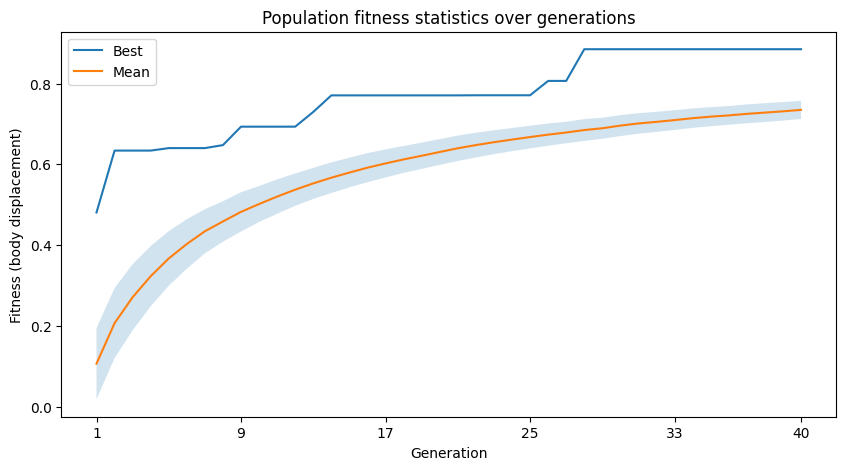

In [12]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=generations, y=generational_best, label="Best")
sns.lineplot(x=generations, y=generational_means, label="Mean")
plt.fill_between(generations, generational_means - generational_stds, generational_means + generational_stds, alpha=0.2)
gen_labels = [int(g) for g in generations]
max_gen = max(gen_labels)
while len(gen_labels) > 10:
    gen_labels = gen_labels[::2]
    if 1 not in gen_labels:
        gen_labels = [1] + gen_labels
    if max_gen not in gen_labels:
        gen_labels = gen_labels + [max_gen]
gen_labels = [str(g) for g in gen_labels]
plt.xticks(gen_labels)
plt.xlabel("Generation")
plt.ylabel("Fitness (body displacement)")
plt.title("Population fitness statistics over generations")
plt.legend()

**Select a generation from which to plot the best robot**

In [13]:
generation = int(generations[-1])

**Where to save robot and simulation results for dynamic visualization**

In [14]:
viz_outdir = "./tmp-viz/gen-{}".format(generation)
print("Visualization output directory: ", viz_outdir)
if not os.path.exists(viz_outdir):
    os.makedirs(viz_outdir)

Visualization output directory:  ./tmp-viz/gen-40


**Load the robots**

In [15]:
with open(os.path.join(outdir, str(generation), "robots.pkl"), "rb") as f:
    robots = pickle.load(f)

**Select the best**

In [16]:
i = 0
best_robot_points = robots['points'][i]
best_robot_springs = robots['springs'][i]
best_robot_id = robots['id'][i]
best_robot = {
    "points": [best_robot_points],
    "springs": [best_robot_springs],
    "weights": []
}

**Load trained weights**

In [17]:
gen, idx = best_robot_id.split("-")
with open(os.path.join(outdir, gen, "weights", idx, "best.pkl"), "rb") as f:
    best_robot["weights"].append(pickle.load(f))

**Save the phenotype and weights together for simulation**

In [18]:
robot_save_file = os.path.join(viz_outdir, "best_robot.pkl")
print(f"Saving best robot to {robot_save_file}")
with open(robot_save_file, "wb") as f:
    pickle.dump(best_robot, f)

Saving best robot to ./tmp-viz/gen-40/best_robot.pkl


**(optional) View the static robot phenotype**

(0.0125, 0.28750000000000003, 0.08700961894323342, 0.3727980021920982)

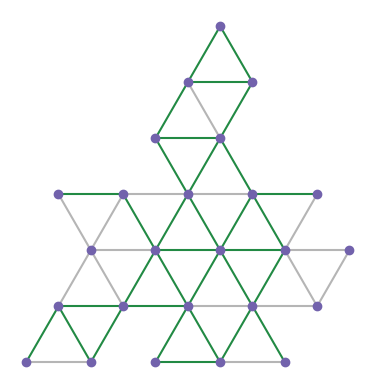

In [19]:
fig = plt.figure()

green = plt.colormaps['Greens'](0.75)
purple = plt.colormaps['Purples'](0.7)
gray = plt.colormaps['Greys'](0.4)

for j in range(len(best_robot_springs)):
    if best_robot_springs[j][-1] == 0:
        c = gray
    else:
        c = green
    plt.plot([best_robot_points[best_robot_springs[j][0]][0], best_robot_points[best_robot_springs[j][1]][0]],
                [best_robot_points[best_robot_springs[j][0]][1], best_robot_points[best_robot_springs[j][1]][1]], color=c)

for i in range(len(best_robot_points)):
    plt.plot(best_robot_points[i][0], best_robot_points[i][1], 'o', color=purple)

plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')


**Command to generate state for dynamic visualization (don't forget to run it!!)**

In [20]:
print(f"python visualize.py {robot_save_file} {viz_outdir}")

python visualize.py ./tmp-viz/gen-40/best_robot.pkl ./tmp-viz/gen-40


**RUN THIS ^^^ !!!!**

**Load state data for dynamic visualization**

In [21]:
state_dir = os.path.join(viz_outdir, "state")
x = np.load(os.path.join(state_dir, "x.npy"))[0]
v = np.load(os.path.join(state_dir, "v.npy"))[0]
act = np.load(os.path.join(state_dir, "act.npy"))[0]
spring_actuation = np.load(os.path.join(state_dir, "spring_actuation.npy"))[0]
spring_anchor_a = np.load(os.path.join(state_dir, "spring_anchor_a.npy"))[0]
spring_anchor_b = np.load(os.path.join(state_dir, "spring_anchor_b.npy"))[0]
center = np.load(os.path.join(state_dir, "center.npy"))[0]
loss = np.load(os.path.join(state_dir, "loss.npy"))[0]

**Make directory to save visualization frames**

In [22]:
os.makedirs(os.path.join(viz_outdir, "frames"), exist_ok=True)

**Generate frames**

In [23]:
x_min, x_max = np.min(x[:, :, 0]), np.max(x[:, :, 0])
y_min, y_max = np.min(x[:, :, 1]), np.max(x[:, :, 1])

gray = plt.colormaps['Greys'](0.4)
greens = plt.colormaps['Greens']
purples = plt.colormaps['Purples']

steps = x.shape[0]

offx = []
offy = []
vx = []
vy = []

for t in range(steps):
    offx.append(x[t, :, 0] - center[t, 0])
    offy.append(x[t, :, 1] - center[t, 1])
    vx.append(v[t, :, 0])
    vy.append(v[t, :, 1])

offx = np.array(offx)
offy = np.array(offy)
vx = np.array(vx)
vy = np.array(vy)

offx = 0.0 + (offx - np.min(offx)) * (1.0 / (np.max(offx) - np.min(offx)))
offy = 0.0 + (offy - np.min(offy)) * (1.0 / (np.max(offy) - np.min(offy)))
vx = 0.25 + (vx - np.min(vx)) * (1.0 / (np.max(vx) - np.min(vx)))
vy = 0.25 + (vy - np.min(vy)) * (1.0 / (np.max(vy) - np.min(vy)))

for t in tqdm(range(0, steps, 2)):
    fig = plt.figure(figsize=(10, 5))

    for j in range(act.shape[1]):
        if spring_actuation[j] == 0:
            c = gray
        else:
            a = act[t, j]
            c = greens((a + 2) / 3)
        plt.plot([x[t, spring_anchor_a[j], 0], x[t, spring_anchor_b[j], 0]],
                 [x[t, spring_anchor_a[j], 1], x[t, spring_anchor_b[j], 1]], color=c)

    for i in range(x.shape[1]):
        c0 = purples(offx[t, i])
        c1 = purples(offy[t, i])
        c2 = purples(vx[t, i])
        c3 = purples(vy[t, i])
        plt.plot(x[t, i, 0], x[t, i, 1], 'o', color=c2, markersize=8)
        plt.plot(x[t, i, 0], x[t, i, 1], 'o', color=c3, markersize=6)
        plt.plot(x[t, i, 0], x[t, i, 1], 'o', color=c0, markersize=4)
        plt.plot(x[t, i, 0], x[t, i, 1], 'o', color=c1, markersize=2)

    plt.hlines(0.0915, x_min, x_max, color='black')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(x_min - 0.05, x_max + 0.05)
    plt.ylim(y_min - 0.05, y_max + 0.05)
    plt.text(x_min - 0.015, 0.06, "0.0")
    plt.text(x_max - 0.025, 0.06, f"{np.round(x_max - 0.025, 2)}")
    plt.tight_layout()
    plt.savefig(os.path.join(viz_outdir, "frames", f"{t}.png"))
    plt.close()


  0%|          | 1/500 [00:00<00:51,  9.76it/s]

100%|██████████| 500/500 [00:55<00:00,  9.02it/s]


**Create and save video from image frames**

In [24]:
frames = os.listdir(os.path.join(viz_outdir, "frames"))
frames.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
frames = [os.path.join(viz_outdir, "frames", f) for f in frames]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=100)
clip.write_videofile(os.path.join(viz_outdir, "sim.mp4"))

Moviepy - Building video ./tmp-viz/gen-40/sim.mp4.
Moviepy - Writing video ./tmp-viz/gen-40/sim.mp4



Moviepy - Done !
Moviepy - video ready ./tmp-viz/gen-40/sim.mp4


**Load the video**

In [25]:
Video(os.path.join(viz_outdir, "sim.mp4"), width=800, height=400)